# Exercise4 Report - camvid

## lesson
* lession 3 Multi-label classification and Segmentation

## student
* 20161622 이예은

## Image segmentation with CamVid

**Image segmentation** is the process of taking a digital image and segmenting it into multiple segments of pixels. 
CAMVID is example of Image segmentation

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Any edits to libraries you make are reloaded here automatically and any charts or images displayed are shown in this notebook.

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
#import neccesary library

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()
# untar CAMVID data

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

# set path for labels and images

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

# get data image files and show that name

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05010.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01740.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03300.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
# get label image files and show that name

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06480_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08340_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05760_P.png')]

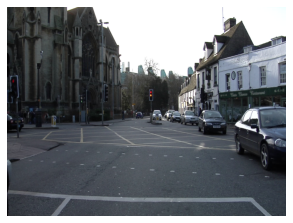

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
# show data images

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
# get pixel labeled image file

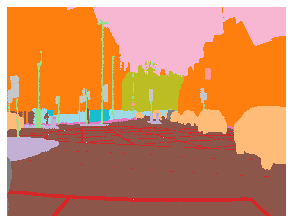

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
# show mask images (pixel labeled) 

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data
# get size of mask image and show data from mask image.
# mask data composed the tensor about labeled data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes
# codes have classes mapping to each mask data of pixel's integers.

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

# Decrease src size in half
# Set bs by GPU RAM size

using bs=8, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
# Split data by vliad.txt (To void validation with similar images(BC these image from video))
# and labels pixel using get_y_fn, codes 

In this type of data, Y(training result data) also need to transform. Because If training data is transformed, the training results are not mapping to it.    

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

# create databunch 
# tfm_y : transform result datas
# normalize data using imagenet_stats


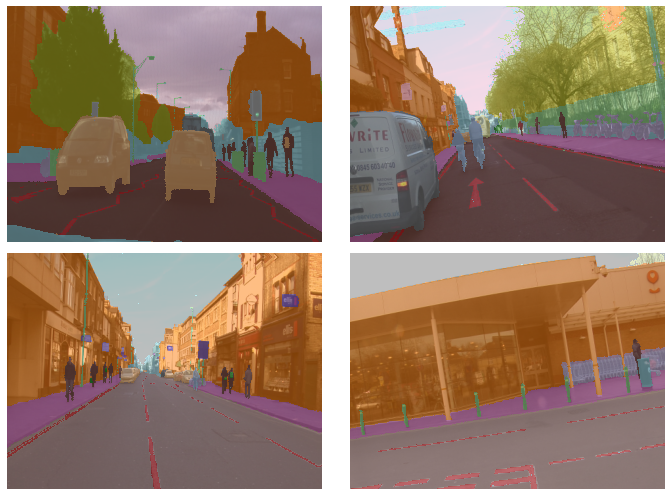

In [16]:
data.show_batch(2, figsize=(10,7))

# show a batch of data

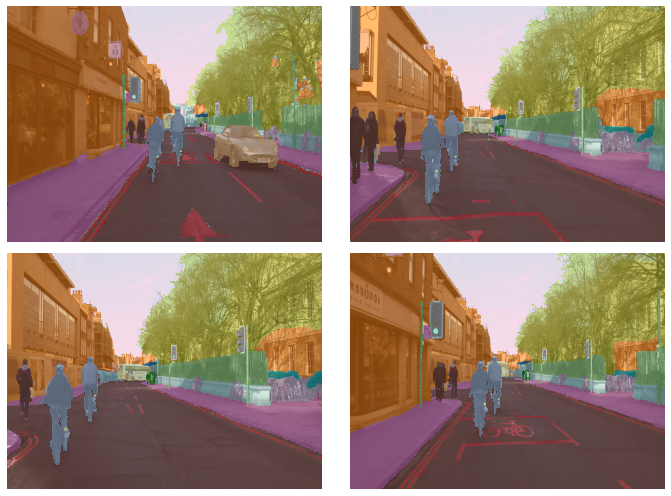

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)
# show a batch of validation set

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# defile function for get accuracy in camvid data

In [0]:
metrics=acc_camvid
# metrics=accuracy

# set metrics to acc_camvid function

learning rate를 서서히 높혔다가 줄이면 더 빠르게 loss를 줄어든다

In [0]:
wd=1e-2
# set wait decay

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# set learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


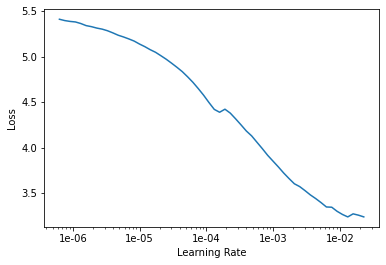

In [22]:
lr_find(learn)
learn.recorder.plot()

#fild learning rate

In [0]:
lr=3e-3
# set learning rate

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
# learn 10 cycles slice 
# pct_start : Percentage of total number of epochs when learning rate rises during one cycle.

epoch,train_loss,valid_loss,acc_camvid,time
0,1.384961,0.923491,0.794123,00:55
1,0.907653,0.627237,0.839163,00:51
2,0.740288,0.601928,0.840447,00:51
3,0.691554,0.517878,0.857403,00:51
4,0.588763,0.486358,0.869579,00:51
5,0.677033,0.536617,0.848520,00:51
6,0.614658,0.446777,0.887343,00:51
7,0.569451,0.470257,0.871815,00:51
8,0.531482,0.437738,0.883278,00:51
9,0.462245,0.353377,0.897869,00:51


In [0]:
learn.save('stage-1')
# save model's parameters

In [0]:
learn.load('stage-1');
# load model's parameters

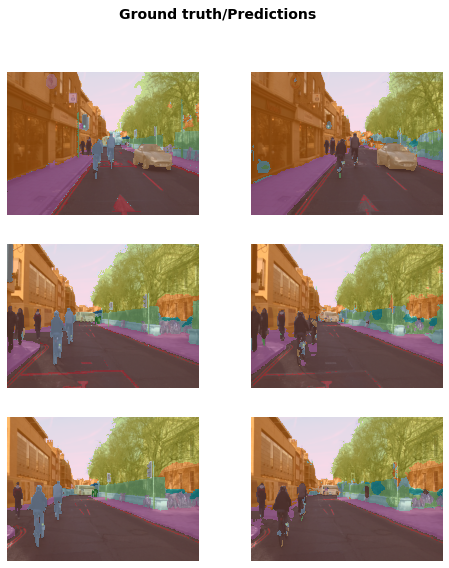

In [27]:
learn.show_results(rows=3, figsize=(8,9))
# show result of learning

In [0]:
learn.unfreeze()
# learn using entire models

In [0]:
lrs = slice(lr/400,lr/4)
#set learning rate

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)
# learn 12 cycles

epoch,train_loss,valid_loss,acc_camvid,time
0,0.399495,0.340663,0.900865,00:53
1,0.385993,0.337848,0.903518,00:53
2,0.373457,0.316940,0.911718,00:53
3,0.360299,0.310496,0.912653,00:53
4,0.355203,0.302898,0.916026,00:53
5,0.346943,0.297925,0.917325,00:53
6,0.332426,0.282251,0.921197,00:52
7,0.322555,0.299047,0.912202,00:52
8,0.312821,0.307212,0.917536,00:52
9,0.301901,0.265093,0.929377,00:53


In [0]:
learn.save('stage-2');
# save paramters of learning rate

## Go big

Try it again original image size

In [32]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

# set batchsize by GPU RAM

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15559MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

# create normalize databunch without reducing image size

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# set learner using unet_learner

In [0]:
learn.load('stage-2');
# load parameter of model

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


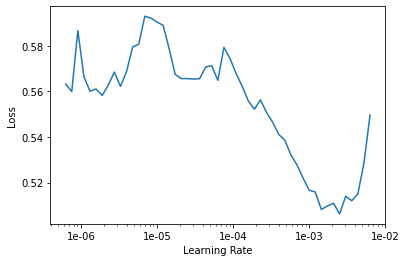

In [36]:
lr_find(learn)
learn.recorder.plot()
#find and plot learning rate and result 

In [0]:
lr=1e-3
#set learning rate

In [38]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)
# learn 10 cycles
# I can see better accuracy compared to result trained by half size image

epoch,train_loss,valid_loss,acc_camvid,time
0,0.392375,0.297880,0.919156,03:36
1,0.353793,0.294426,0.917568,03:33
2,0.330187,0.316485,0.914244,03:33
3,0.331332,0.296818,0.916862,03:33
4,0.344333,0.370083,0.899918,03:33
5,0.347245,0.277233,0.926717,03:33
6,0.314760,0.316796,0.912971,03:33
7,0.342715,0.354720,0.907010,03:33
8,0.298858,0.276170,0.927787,03:33
9,0.229272,0.246367,0.933527,03:33


In [0]:
learn.save('stage-1-big')
# save learning model

In [0]:
learn.load('stage-1-big')
# load model

In [0]:
learn.unfreeze()
# learn using entire model

In [0]:
lrs = slice(1e-6,lr/10)
# set learning rate

In [43]:
learn.fit_one_cycle(10, lrs)
# learn 10 cycles 
# I can see better accuracy compared to result trained by half size image

epoch,train_loss,valid_loss,acc_camvid,time
0,0.216071,0.250168,0.933022,03:40
1,0.225291,0.243609,0.934264,03:40
2,0.219677,0.252398,0.932377,03:40
3,0.213611,0.244521,0.934454,03:39
4,0.211551,0.251306,0.932268,03:39
5,0.198671,0.251650,0.933912,03:39
6,0.198845,0.252035,0.933936,03:39
7,0.196568,0.244309,0.935220,03:39
8,0.192644,0.249982,0.934820,03:39
9,0.190734,0.246547,0.935361,03:39


In [0]:
learn.save('stage-2-big')
# save the model

In [0]:
learn.load('stage-2-big');
# load the model

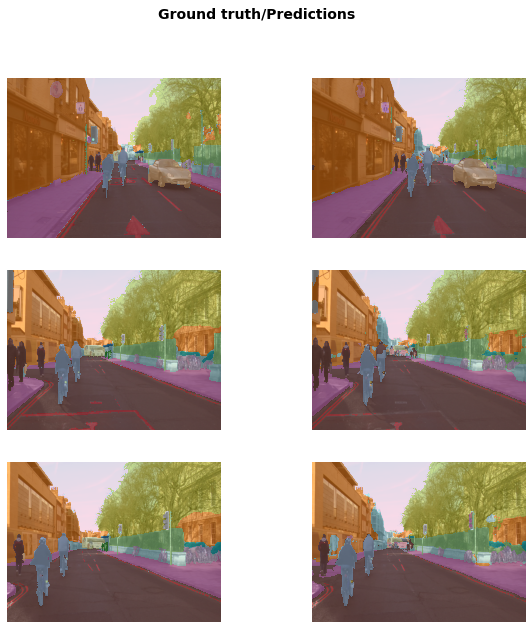

In [46]:
learn.show_results(rows=3, figsize=(10,10))
# show result of model

## fin